In [ ]:
# conda install -c conda-forge catboost

In [45]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ndcg_score, make_scorer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from scipy.stats import randint as sp_randint

In [3]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
random_seed = 1106
set_random_seed(random_seed)

In [24]:
train = pd.read_csv('train_users_2.csv')
session = pd.read_csv('sessions.csv')

## Train 전처리

In [25]:
# train 전처리
train.rename(columns={'id':'user_id'},inplace=True)
train['timestamp_first_active'] = pd.to_datetime(train['timestamp_first_active'], format = '%Y%m%d%H%M%S')
train['date_account_created'] = pd.to_datetime(train['date_account_created'])
train['date_first_booking'] = pd.to_datetime(train['date_first_booking'], errors='coerce')

In [66]:
train.isnull().sum()

user_id                         0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

### age 전처리
- 18세 이하는 가입이 불가능하니 해당되는 나이는 0으로 대체
- 1000이상인 값은 태어난 연도로 간주하여 계정 생성연도에서 뺀 나이로 대체(음수가 나오면 0으로 대체)
- 결측치는 25% - 75%분위 사이의 랜덤 숫자로 채워넣기

In [27]:
train2 = train.copy()

In [30]:
train['age'].describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [28]:
train2['first_affiliate_tracked'].fillna('untracked', inplace=True)
# 18세 이하는 0으로
train2['age'] = train2['age'].apply(lambda x: 0 if x < 18 else x)

# 1000이상인 값은 태어난 년도로 간주하여 계정 생성연도를 추출하여 나이를 채운다
current_year = pd.to_datetime(train2['date_account_created']).dt.year
birth_year = current_year - train2['age']
train2['age'] = np.where(train2['age'] > 1000, np.where(birth_year > 0, birth_year, 0), train2['age'])

# NaN값과 100 이상의 값들은 위의 통계값을 이용하여 25% - 75% 사이의 랜덤 값으로 채우기
percentile_25 = train2['age'].quantile(0.25)
percentile_75 = train2['age'].quantile(0.75)

def replace_age(x):
    if np.isnan(x) or x > 100:
        return np.random.randint(percentile_25, percentile_75 + 1)
    return x

train2['age'] = train2['age'].apply(replace_age)

## Session 전처리

In [5]:
session.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [6]:
session.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [7]:
# user_id가 존재하지 않는 것은 삭제 -> train이랑 머지가 불가능한 데이터
session.dropna(subset='user_id', inplace=True)

In [15]:
session['action'].replace('-unknown-', 'unknown', inplace=True)
session['action_type'].replace('-unknown-', 'unknown', inplace=True)
session['action_detail'].replace('-unknown-', 'unknown', inplace=True)
session['device_type'].replace('-unknown-', 'unknown', inplace=True)

In [9]:
session['action'].fillna('unknown', inplace=True)
session['action_type'].fillna('unknown', inplace=True)
session['action_detail'].fillna('unknown', inplace=True)

In [10]:
session['secs_elapsed'].fillna(0, inplace=True)

In [11]:
# user_flow 컬럼 생성
session['user_flow'] = session['action'].astype('str') + '+' + session['action_type'].astype('str') + '+' + session['action_detail'].astype('str')

### action columns

- action+type+detail = user_flow로 묶고 user_id 별 모든 user_flow를 한 string으로 합치기
- train과 머지했을 때 중복을 피하기 위함
- 구분자는 쉼표

In [12]:
user_flows_concatenated = session.groupby('user_id')['user_flow'].apply(lambda x: ','.join(x)).reset_index()

session = pd.merge(session.drop(columns=['user_flow']), user_flows_concatenated, on='user_id', how='left')

In [16]:
session_df = session.copy()

### feature engineering
- user_id별 평균 세션 시간 생성
- user_id별 가장 많이 쓴 주요 device_type 생성
- user_id별 세션 총 개수 생성

In [46]:
# user_id별 평균 secs_elapsed column 생성
session_df['mean_secs_elapsed'] = session_df.groupby('user_id')['secs_elapsed'].transform('mean')
# user_id별 가장 빈도수가 높은 device_type column 생성
session_df['most_frequent_device'] = session_df.groupby('user_id')['device_type'].transform(lambda x: x.mode()[0])
# user_id별 세션 총 개수
session_df['session_count'] = session_df.groupby('user_id')['action'].transform('count')

In [38]:
len(session_df['user_id'].unique())

135483

In [48]:
session_df2 = session_df.copy()

In [49]:
session_df2.drop(['action', 'action_type', 'action_detail', 'device_type', 'secs_elapsed'], axis=1, inplace=True)

In [50]:
session_df2.drop_duplicates(subset='user_id', inplace=True)

## train, session merge

In [52]:
merged_df = pd.merge(train2, session_df2, on='user_id', how='inner')

# Modeling

In [60]:
# NDCG metric 이용하여 확인
X = merged_df.drop(['user_id', 'date_first_booking', 'country_destination'], axis=1)
y = merged_df['country_destination']

cat_features = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider',
                'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'user_flow',
                'most_frequent_device']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

model = CatBoostClassifier(iterations=100, 
                            learning_rate=0.1, 
                            depth=6, 
                            loss_function='MultiClass',
                            cat_features=cat_features,
                            random_seed=random_seed)

model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=20)
y_pred_probs = model.predict_proba(X_test)

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

ndcg = ndcg_score(y_test_bin, y_pred_probs)

print("NDCG Score:", ndcg)

0:	learn: 2.0356865	test: 2.0386804	best: 2.0386804 (0)	total: 661ms	remaining: 1m 5s
20:	learn: 1.0755510	test: 1.0907031	best: 1.0907031 (20)	total: 10.3s	remaining: 38.9s
40:	learn: 1.0254283	test: 1.0463715	best: 1.0463715 (40)	total: 23.2s	remaining: 33.4s
60:	learn: 1.0152386	test: 1.0405065	best: 1.0405065 (60)	total: 38.1s	remaining: 24.3s
80:	learn: 1.0096798	test: 1.0383157	best: 1.0383157 (80)	total: 57.8s	remaining: 13.6s
99:	learn: 1.0049231	test: 1.0366896	best: 1.0366896 (99)	total: 1m 12s	remaining: 0us

bestTest = 1.036689644
bestIteration = 99

NDCG Score: 0.8412432583830272


In [64]:
feature_importance = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
2,gender,27.486336
14,mean_secs_elapsed,9.878797
3,age,8.625055
4,signup_method,6.486867
15,most_frequent_device,6.275407
16,session_count,6.163906
9,first_affiliate_tracked,6.068979
11,first_device_type,5.942821
12,first_browser,5.107344
7,affiliate_channel,5.033197


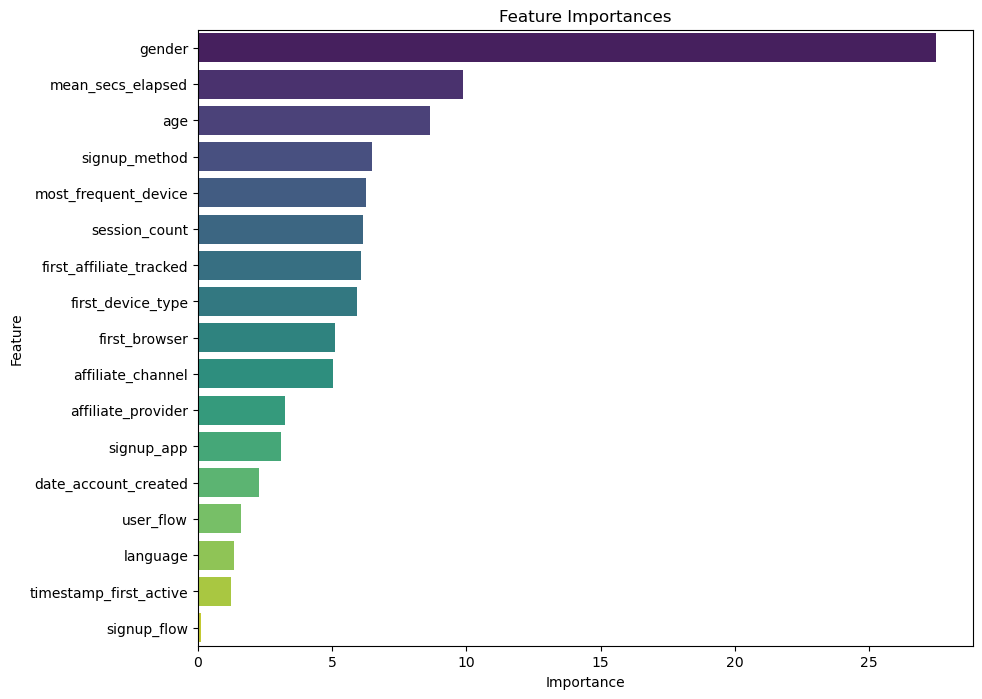

In [65]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

### Ideas
- action 관련 컬럼들을 모아 TF-IDF를 구해보면 어떨까..?

In [69]:
merged_df2 = merged_df.copy()

### TF-IDF 시도
- 첫 시도 : NDCG Score: 0.8597143850429759
- 두번째 시도 : NDCG Score: 0.8616180814327093

In [70]:
# tf-idf
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df2['user_flow'])

# TF-IDF를 기존 데이터프레임에 추가
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
merged_df_with_tfidf = pd.concat([merged_df2, tfidf_df], axis=1)

# TF-IDF를 적용한 데이터에서 불필요한 열 제거
merged_df_with_tfidf.drop(['user_flow'], axis=1, inplace=True)

In [52]:
X = merged_df_with_tfidf.drop(['user_id', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'country_destination'], axis=1)
y = merged_df_with_tfidf['country_destination']

cat_features = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider',
                'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser',
                'most_frequent_device']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

model = CatBoostClassifier(iterations=100, 
                            learning_rate=0.1, 
                            depth=6, 
                            loss_function='MultiClass',
                            cat_features=cat_features,
                            random_seed=random_seed)

model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=20)
y_pred_probs = model.predict_proba(X_test)

lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)

ndcg = ndcg_score(lb.transform(y_test), y_pred_probs)

print("NDCG Score:", ndcg)

0:	learn: 2.0150224	test: 2.0184679	best: 2.0184679 (0)	total: 1.02s	remaining: 1m 40s
20:	learn: 1.0034806	test: 1.0227672	best: 1.0227672 (20)	total: 24.6s	remaining: 1m 32s
40:	learn: 0.9518092	test: 0.9780390	best: 0.9780390 (40)	total: 47.2s	remaining: 1m 7s
60:	learn: 0.9390181	test: 0.9702637	best: 0.9702637 (60)	total: 1m 11s	remaining: 45.5s
80:	learn: 0.9306522	test: 0.9662949	best: 0.9662949 (80)	total: 1m 34s	remaining: 22.3s
99:	learn: 0.9252419	test: 0.9638447	best: 0.9638447 (99)	total: 1m 56s	remaining: 0us

bestTest = 0.9638446803
bestIteration = 99

NDCG Score: 0.8597143850429759


In [74]:
feature_importance = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df[:15]

,Feature,Importance
268,pending,14.777313
0,gender,14.436853
1,age,7.654045
79,booking_request,6.602106
227,message_post,3.726283
5,affiliate_channel,3.537649
2,signup_method,2.962236
105,complete_status,2.845731
108,confirm_email_link,2.035548
250,other_hosting_reviews_first,1.247975


In [78]:
# 예측된 상위 5개의 나라 확인
top5_pred_indices = np.argsort(y_pred_probs, axis=1)[:, ::-1][:, :5]

# Convert top 5 indices to country labels
top5_pred_countries = model.classes_[top5_pred_indices]

print("Top 5 Predicted Countries:")
print(top5_pred_countries)

Top 5 Predicted Countries:
[['US' 'NDF' 'other' 'FR' 'GB']
 ['US' 'NDF' 'other' 'IT' 'FR']
 ['NDF' 'US' 'other' 'FR' 'ES']
 ...
 ['NDF' 'US' 'other' 'FR' 'IT']
 ['NDF' 'US' 'other' 'FR' 'IT']
 ['NDF' 'US' 'other' 'FR' 'IT']]


In [5]:
# RandomizedSearch에 사용하기 위해 커스텀 ndcg scorer 생성 -> 아직 사용 안함
def ndcg_scorer(y_true, y_pred_proba):
    ndcg = ndcg_score(y_true, y_pred_proba)
    return ndcg

In [88]:
# iterations 200, lr 0.1로 시도
# 하지만 이건 타깃 클래스의 밸런스를 고려하지 않은 것
X = merged_df_with_tfidf.drop(['user_id', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'country_destination'], axis=1)
y = merged_df_with_tfidf['country_destination']

cat_features = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider',
                'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser',
                'most_frequent_device']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

model = CatBoostClassifier(iterations=200, 
                            learning_rate=0.1, 
                            depth=6, 
                            loss_function='MultiClass',
                            cat_features=cat_features,
                            random_seed=random_seed)

model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=40)
y_pred_probs = model.predict_proba(X_test)

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

ndcg = ndcg_score(y_test_bin, y_pred_probs)

print("NDCG Score:", ndcg)

0:	learn: 1.9945415	test: 1.9974639	best: 1.9974639 (0)	total: 2.19s	remaining: 7m 15s
40:	learn: 0.9536806	test: 0.9792004	best: 0.9792004 (40)	total: 1m 48s	remaining: 6m 59s
80:	learn: 0.9321045	test: 0.9670333	best: 0.9670333 (80)	total: 3m 39s	remaining: 5m 23s
120:	learn: 0.9188383	test: 0.9618860	best: 0.9618860 (120)	total: 5m 31s	remaining: 3m 36s
160:	learn: 0.9086073	test: 0.9596349	best: 0.9596349 (160)	total: 7m 4s	remaining: 1m 42s
199:	learn: 0.8999245	test: 0.9582531	best: 0.9582531 (199)	total: 8m 43s	remaining: 0us

bestTest = 0.9582530746
bestIteration = 199

NDCG Score: 0.8616180814327093


## StratifiedKFold 사용
- 타깃 클래스의 밸런스가 맞지 않기 때문에 Stratified한 방식 사용

In [89]:
# StratifiedKFold 사용
n_splits = 3

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

model = CatBoostClassifier(iterations=100, 
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='MultiClass',
                           cat_features=cat_features,
                           random_seed=random_seed,
                           verbose=40)

ndcg_scores = []

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold, eval_set=(X_test_fold, y_test_fold))
    
    y_pred_probs_fold = model.predict_proba(X_test_fold)
    
    ndcg_fold = ndcg_score(lb.transform(y_test_fold), y_pred_probs_fold)
    ndcg_scores.append(ndcg_fold)

mean_ndcg = np.mean(ndcg_scores)
print("Mean NDCG Score:", mean_ndcg)

0:	learn: 2.0141036	test: 2.0155498	best: 2.0155498 (0)	total: 1.17s	remaining: 1m 55s
40:	learn: 0.9555261	test: 0.9682831	best: 0.9682831 (40)	total: 48.9s	remaining: 1m 10s
80:	learn: 0.9329150	test: 0.9556343	best: 0.9556343 (80)	total: 1m 39s	remaining: 23.3s
99:	learn: 0.9271819	test: 0.9533230	best: 0.9533230 (99)	total: 2m 4s	remaining: 0us

bestTest = 0.9533230415
bestIteration = 99

0:	learn: 2.0156254	test: 2.0146963	best: 2.0146963 (0)	total: 1.2s	remaining: 1m 59s
40:	learn: 0.9552267	test: 0.9664241	best: 0.9664241 (40)	total: 53.4s	remaining: 1m 16s
80:	learn: 0.9326867	test: 0.9550161	best: 0.9550161 (80)	total: 1m 39s	remaining: 23.4s
99:	learn: 0.9262918	test: 0.9527377	best: 0.9527377 (99)	total: 2m 2s	remaining: 0us

bestTest = 0.9527377308
bestIteration = 99

0:	learn: 2.0111178	test: 2.0105868	best: 2.0105868 (0)	total: 985ms	remaining: 1m 37s
40:	learn: 0.9561544	test: 0.9633536	best: 0.9633536 (40)	total: 46.4s	remaining: 1m 6s
80:	learn: 0.9349929	test: 0.95141

In [7]:
cat_features = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider',
                'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser',
                'most_frequent_device']

In [9]:
X = merged_df_with_tfidf.drop(['user_id', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'country_destination'], axis=1)
y = merged_df_with_tfidf['country_destination']

In [13]:
# feature 그대로, iterations만 다르게 진행
n_splits = 3

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

model = CatBoostClassifier(iterations=200, 
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='MultiClass',
                           cat_features=cat_features,
                           random_seed=random_seed,
                           verbose=40)

ndcg_scores = []

lb = LabelBinarizer()
lb.fit(y)

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold, eval_set=(X_test_fold, y_test_fold))
    
    y_pred_probs_fold = model.predict_proba(X_test_fold)
    
    ndcg_fold = ndcg_score(lb.transform(y_test_fold), y_pred_probs_fold)
    ndcg_scores.append(ndcg_fold)

mean_ndcg = np.mean(ndcg_scores)
print("Mean NDCG Score:", mean_ndcg)

0:	learn: 1.9953136	test: 1.9967430	best: 1.9967430 (0)	total: 1.54s	remaining: 5m 6s
40:	learn: 0.9540933	test: 0.9662123	best: 0.9662123 (40)	total: 1m 12s	remaining: 4m 40s
80:	learn: 0.9323213	test: 0.9537125	best: 0.9537125 (80)	total: 2m 22s	remaining: 3m 29s
120:	learn: 0.9185497	test: 0.9494213	best: 0.9494213 (120)	total: 3m 32s	remaining: 2m 19s
160:	learn: 0.9071476	test: 0.9469884	best: 0.9469884 (160)	total: 4m 38s	remaining: 1m 7s
199:	learn: 0.8980741	test: 0.9455860	best: 0.9455860 (199)	total: 5m 40s	remaining: 0us

bestTest = 0.9455860303
bestIteration = 199

0:	learn: 1.9911600	test: 1.9910313	best: 1.9910313 (0)	total: 1.52s	remaining: 5m 2s
40:	learn: 0.9576103	test: 0.9677688	best: 0.9677688 (40)	total: 1m 10s	remaining: 4m 34s
80:	learn: 0.9370525	test: 0.9564137	best: 0.9564137 (80)	total: 2m 21s	remaining: 3m 27s
120:	learn: 0.9219716	test: 0.9504473	best: 0.9504473 (120)	total: 3m 31s	remaining: 2m 18s
160:	learn: 0.9092072	test: 0.9472908	best: 0.9472908 (160

In [15]:
feature_importances = model.feature_importances_

features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [16]:
importance_df

,Feature,Importance
0,gender,13.565267
79,booking_request,8.037619
1,age,7.537714
227,message_post,5.516404
9,first_device_type,3.201249
...,...,...
187,hosting_social_proof,0.000000
186,host_summary,0.000000
185,host_respond,0.000000
183,host_guarantee,0.000000


In [50]:
# 중요도가 낮은 피처들 제거
low_importance_feat = importance_df[importance_df['Importance'] < 0.01]['Feature'].to_list()
# low_importance_feat

In [19]:
len(low_importance_feat)

289

### feature 제거
- 중요도가 0.01보다 낮은 피처를 제거하고 다시 시도

In [35]:
cat_features2 = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider',
                'first_affiliate_tracked', 'signup_app', 'first_device_type',
                'most_frequent_device']

In [37]:
cols_to_drop = ['user_id', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'country_destination']
combined_list = cols_to_drop + low_importance_feat

X2 = merged_df_with_tfidf.drop(combined_list, axis=1)
y2 = merged_df_with_tfidf['country_destination']

In [38]:
n_splits = 3
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

model = CatBoostClassifier(iterations=200, 
                           learning_rate=0.1, 
                           depth=6, 
                           loss_function='MultiClass',
                           cat_features=cat_features2,
                           random_seed=random_seed,
                           verbose=40)

ndcg_scores = []

lb = LabelBinarizer()
lb.fit(y2)

for train_index, test_index in skf.split(X2, y2):
    X_train_fold, X_test_fold = X2.iloc[train_index], X2.iloc[test_index]
    y_train_fold, y_test_fold = y2.iloc[train_index], y2.iloc[test_index]
    
    model.fit(X_train_fold, y_train_fold, eval_set=(X_test_fold, y_test_fold))
    
    y_pred_probs_fold = model.predict_proba(X_test_fold)
    
    ndcg_fold = ndcg_score(lb.transform(y_test_fold), y_pred_probs_fold)
    ndcg_scores.append(ndcg_fold)

mean_ndcg = np.mean(ndcg_scores)
print("Mean NDCG Score:", mean_ndcg)

0:	learn: 1.9880020	test: 1.9899375	best: 1.9899375 (0)	total: 1.26s	remaining: 4m 10s
40:	learn: 0.9555220	test: 0.9670932	best: 0.9670932 (40)	total: 1m	remaining: 3m 53s
80:	learn: 0.9320076	test: 0.9536960	best: 0.9536960 (80)	total: 2m 1s	remaining: 2m 58s
120:	learn: 0.9177474	test: 0.9495016	best: 0.9495016 (120)	total: 3m 1s	remaining: 1m 58s
160:	learn: 0.9032043	test: 0.9461865	best: 0.9461865 (160)	total: 3m 56s	remaining: 57.2s
199:	learn: 0.8918423	test: 0.9448538	best: 0.9448538 (199)	total: 4m 50s	remaining: 0us

bestTest = 0.9448538012
bestIteration = 199

0:	learn: 2.0098460	test: 2.0107668	best: 2.0107668 (0)	total: 1.1s	remaining: 3m 39s
40:	learn: 0.9558826	test: 0.9675408	best: 0.9675408 (40)	total: 1m 1s	remaining: 3m 58s
80:	learn: 0.9332032	test: 0.9554453	best: 0.9554453 (80)	total: 1m 59s	remaining: 2m 55s
120:	learn: 0.9179083	test: 0.9501677	best: 0.9501677 (120)	total: 2m 55s	remaining: 1m 54s
160:	learn: 0.9040085	test: 0.9472475	best: 0.9472305 (159)	tota